## Feature Selection and Regularization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    RFE,
    RFECV,
    SelectFromModel,
    f_classif,
    mutual_info_classif
)
from sklearn.preprocessing import StandardScaler

### Data Loading and Scaling

Scale data and remove constant or quasi-constant features.

In [3]:
train_df = pd.read_csv('data/train.csv')

X_train = train_df.drop('class_encoded', axis=1)
y_train = train_df['class_encoded']

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)


selector_variance = VarianceThreshold(threshold=0.01)
X_train_v = selector_variance.fit_transform(X_train_scaled)
features_after_v = X_train_scaled.columns[selector_variance.get_support()]
X_train_v = pd.DataFrame(X_train_v, columns=features_after_v)
X_train_v


,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_encoded
0,-0.050166,-1.926133,-1.674047,0.841188,-1.455195,-1.636862,-1.743004,-1.097682,-1.943537,-1.212709,1.315047
1,-0.492543,0.001630,1.076106,-0.357107,0.119963,1.005457,2.411620,1.181885,1.547914,1.876620,-0.760429
2,1.424423,0.691817,0.424094,-0.343333,1.787778,1.411968,-0.267266,0.398284,-0.686614,-0.358748,-0.760429
3,1.866800,-1.224046,-0.721106,0.703453,0.119963,-0.146323,-0.962837,0.730721,-1.454734,-1.338291,1.315047
4,-0.787461,-0.141167,0.666509,1.171752,0.861214,0.124684,1.180272,-0.468427,1.128940,0.545446,-0.760429
...,...,...,...,...,...,...,...,...,...,...,...
10039,0.392211,-1.747637,-1.448350,2.301179,-0.250662,-1.365855,-1.122630,0.089593,-1.873708,-0.961544,1.315047
10040,0.392211,-0.736156,-0.562283,0.111193,-1.177225,-2.043372,0.042920,0.754466,0.221163,-0.459214,1.315047
10041,-1.156108,0.822715,0.942360,-1.211064,-1.177225,0.124684,1.866443,0.243938,2.036717,0.897077,-0.760429
10042,-0.787461,0.798915,0.215116,-0.536162,1.787778,1.208713,0.315509,0.137084,0.640137,1.399407,-0.760429


### Ensemble Feature Selection (Majority Voting)

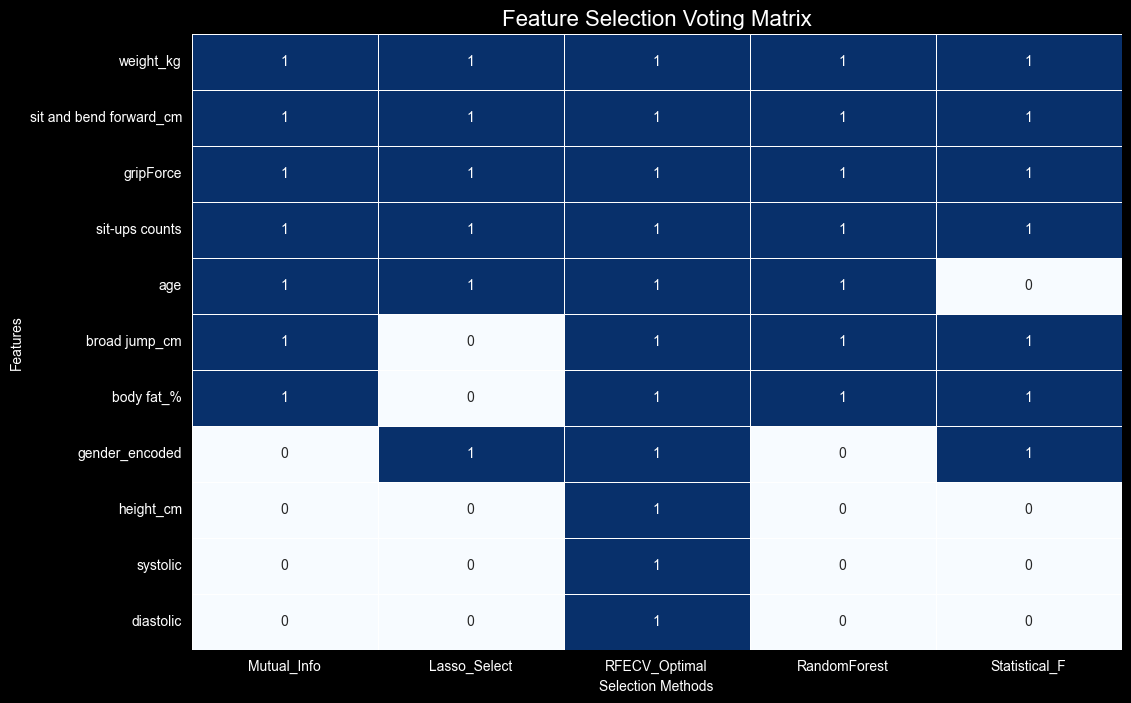

Final feature subset (8 features): ['weight_kg', 'sit and bend forward_cm', 'gripForce', 'sit-ups counts', 'age', 'broad jump_cm', 'body fat_%', 'gender_encoded']


In [5]:
votes = pd.DataFrame(index=features_after_v)
k_best = 7

selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_best)
selector_mi.fit(X_train_v, y_train)
votes['Mutual_Info'] = selector_mi.get_support().astype(int)

lasso_est = LogisticRegression(
    l1_ratio=0.5,
    solver='saga',
    C=0.2,
    max_iter=5000,
    random_state=42
)

lasso_est.fit(X_train_v, y_train)

lasso_selector = SelectFromModel(
    estimator=lasso_est,
    threshold='median',
    prefit=True
)

rf_selector = RandomForestClassifier(n_estimators=50, random_state=42)
rfecv = RFECV(estimator=rf_selector, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train_v, y_train)
votes['RFECV_Optimal'] = rfecv.support_.astype(int)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_v, y_train)
rf_top = np.argsort(rf.feature_importances_)[-k_best:]
votes['RandomForest'] = 0
votes.iloc[rf_top, votes.columns.get_loc('RandomForest')] = 1

votes['Total'] = votes.sum(axis=1)
votes['Lasso_Select'] = lasso_selector.get_support().astype(int)

selector_f = SelectKBest(score_func=f_classif, k=k_best)
selector_f.fit(X_train_v, y_train)
votes['Statistical_F'] = selector_f.get_support().astype(int)

vote_cols = ['Mutual_Info', 'Lasso_Select', 'RFECV_Optimal', 'RandomForest', 'Statistical_F']
votes['Total'] = votes[vote_cols].sum(axis=1)


votes_sorted = votes.sort_values(by='Total', ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(votes_sorted[vote_cols], annot=True, cbar=False, cmap='Blues', linewidths=0.5)
plt.title('Feature Selection Voting Matrix', fontsize=16)
plt.ylabel('Features')
plt.xlabel('Selection Methods')
plt.show()

final_features = votes_sorted[votes_sorted['Total'] >= 3].index.tolist()
print(f"Final feature subset ({len(final_features)} features): {final_features}")

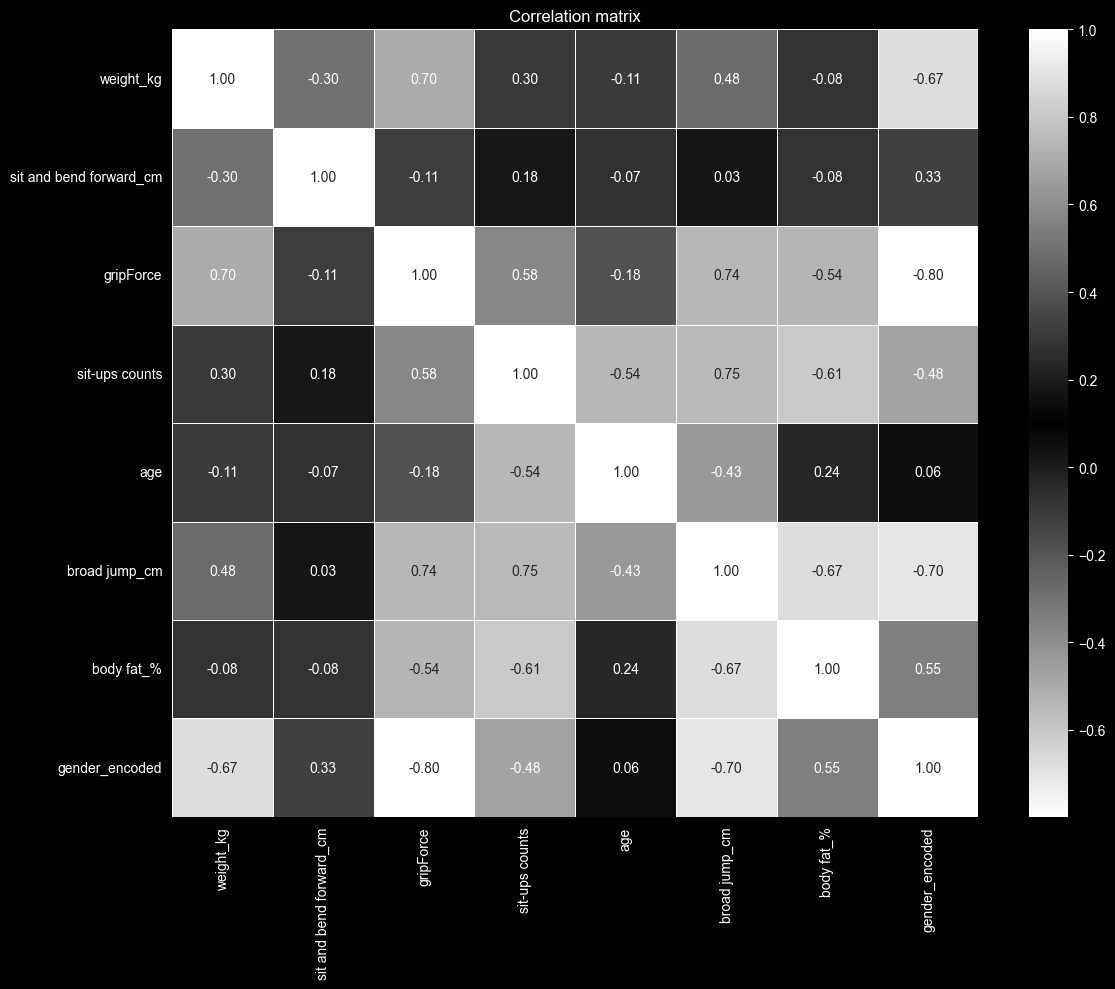

In [6]:
from matplotlib.colors import LinearSegmentedColormap
corr_matrix = X_train_v[final_features].corr()

colors_wbw = ["white", "black", "white"]

cmap_custom = LinearSegmentedColormap.from_list("black_white_black_map", colors_wbw)
plt.figure(figsize=(12, 10))
plt.title('Correlation matrix')
sns.heatmap(corr_matrix, annot=True, cmap=cmap_custom, fmt=".2f", linewidths=0.5)
plt.tight_layout()

### Outlier Detection and Handling

### Establishing Baseline Models

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

dummy_clf = DummyClassifier(strategy="most_frequent")

log_reg = LogisticRegression(
    solver='saga',
    max_iter=10000,
    random_state=42
)

gnb = GaussianNB()

In [10]:

X_train_selected = X_train_v[final_features]


def run_baselines(X, y, title):
    print(f"\n--- {title} ---")

    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_scores = cross_val_score(dummy_clf, X, y, cv=5, scoring='accuracy')

    log_reg = LogisticRegression(solver='saga', max_iter=10000, random_state=42)
    log_reg_scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')

    gnb = GaussianNB()
    gnb_scores = cross_val_score(gnb, X, y, cv=5, scoring='accuracy')

    results = {
        'Naive (Most Frequent)': dummy_scores.mean(),
        'Logistic Regression': log_reg_scores.mean(),
        'Gaussian NB': gnb_scores.mean()
    }

    for model, score in results.items():
        print(f"{model}: {score:.4f}")
    return results


metrics_all = run_baselines(X_train_scaled, y_train, "Baseline: All Features")
metrics_selected = run_baselines(X_train_selected, y_train, "Baseline: Selected Features")


--- Baseline: All Features ---
Naive (Most Frequent): 0.2499
Logistic Regression: 0.6174
Gaussian NB: 0.5474

--- Baseline: Selected Features ---
Naive (Most Frequent): 0.2499
Logistic Regression: 0.6133
Gaussian NB: 0.5456
